# Anemia Types Classification

# Imports

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.pipeline import Pipeline as imbPipeline

# Functions

In [90]:
def check_nulls(df):
  print(f"The amount of Nulls: {df.isna().sum()}")
  print(f"The amount of Duplicates: {df.duplicated().sum()}")

def check_class_imbalances(target):
  
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(17, 12))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 6))
  sns.countplot(x=target)
  plt.xlabel("Classes")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.title("Target Class Breakdown")
  plt.show()

def plot_model_performance(df, y, axis):
  fig, ax = plt.subplots(figsize=(15, 8))
  df.plot.bar(x="Model",y=y, ax=ax)
  ax.set_xlabel("Model")
  ax.set_ylabel(axis)
  ax.set_title("Model Performance")
  plt.legend(y)
  ax.grid(True)
  plt.xticks(rotation=45)
  plt.show()

def grab_selected_models(model_names):
  models = {
    "LR": LogisticRegression(max_iter=1000),
    "SVC": SVC(),
    "KNN":KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "RFC": RandomForestClassifier(),
    "GBC": GradientBoostingClassifier(),
    "XGB": XGBClassifier()
  }
  
  return [models[model] for model in model_names]

def create_pipeline_object(model=None):
  
  steps = steps = [
    ("Scaler", StandardScaler()),
    ("PowerTransformer", PowerTransformer())
  ]
  if model is not None:
    steps.append(
      ("Model", model)
    )
  return Pipeline(steps=steps)

def create_sampling_pipeline(sampling_model, model):
  return imbPipeline(steps=[
    ("sample", sampling_model),
    ("model", model)
  ])

def create_confusion_matrix(y_pred, y_test, model_name, data_type):
  
  plt.figure(figsize=(10, 6))
  cm = confusion_matrix(y_pred, y_test)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix -> Model:{model_name} -> {data_type}")
  plt.xlabel("True Labels")
  plt.ylabel("Predicted Labels")
  plt.xticks(rotation=45)
  plt.show()
  

def evaluate_model(X,y, model):
  
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)
  metric = make_scorer(f1_score, average="micro")
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  return scores

def tested_selected_models(model_names, models, X, y):
  
  model_performance = []
  
  for i in range(len(model_names)):
    model, model_name = models[i], model_names[i]
    pipeline = create_pipeline_object(model)
    scores = evaluate_model(X, y, pipeline)
    model_performance.append({
      "Model":model_name,
      "Mean": round(np.mean(scores),3),
      "STD": round(np.std(scores),3),
    })
  
  model_performance_df = pd.DataFrame(model_performance).sort_values(by="Mean", ascending=False).reset_index()
  plot_model_performance(model_performance_df, ["Mean", "STD"], "Mean")
  print(model_performance_df)

def create_train_test_splits(X, y):
  
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
  
  return X_train, X_test, X_val, y_train, y_test, y_val

def test_predictions(model_names, models, X, y):
  
  X_train, X_test, X_val, y_train, y_test, y_val= create_train_test_splits(X, y)
  model_performance = []
  for i in range(len(models)):
    model_name, model = model_names[i], models[i]
    
    model.fit(X_train, y_train)
    
    val_pred = model.predict(X_val)
    test_pred =model.predict(X_test)
    
    val_acc = accuracy_score(val_pred, y_val)
    test_acc = accuracy_score(test_pred, y_test)
    
    val_f1_score = f1_score(val_pred, y_val, average="micro")
    test_f1_score = f1_score(test_pred, y_test, average="micro")
    
    create_confusion_matrix(test_pred, y_test, model_name, "Test Data")
    
    model_performance.append({
      "Model": model_name,
      "Test-F1-Score": test_f1_score,
      "Val-F1-Score": val_f1_score,
      "Test-Acc": test_acc,
      "Val-Acc": val_acc
    })
  
  model_performance_df = pd.DataFrame(model_performance).sort_values(by="Test-F1-Score", ascending=False).reset_index()
  plot_model_performance(model_performance_df,["Test-F1-Score", "Val-F1-Score", "Test-Acc", "Val-Acc"], "Metrics")
  print(model_performance_df)

def grab_selected_sampling_models(model_names):
  models = {
    "SMOTE":SMOTE(),
    "BL-SMOTE":BorderlineSMOTE(),
    "KNN": SMOTE(k_neighbors=5)
  }
  
  return [models[model_name] for model_name in model_names]

def test_sampling_models(sampling_model_names, sampling_models, model_names, models, X, y):
  
  model_performance = []
  
  for sample_model_name, sample_model in zip(sampling_model_names, sampling_models):
    for model_name, model in zip(model_names, models):
      pipeline = create_sampling_pipeline(sample_model, model)
      scores = evaluate_model(X, y, pipeline)
      model_performance.append({
      "Model":model_name + "-" + sample_model_name,
      "Mean": round(np.mean(scores),3),
      "STD": round(np.std(scores),3),
    })
  
  performance_df = pd.DataFrame(model_performance).sort_values(by="Mean", ascending=False).reset_index()
  plot_model_performance(performance_df,["Mean", "STD"], "Mean")
  print(performance_df)

def test_sampling_model_predictions(sampling_model_names, sampling_models, model_names, models, X, y):
  
  X_train, X_test, X_val, y_train, y_test, y_val= create_train_test_splits(X, y)
  model_performance = []
  for sample_model_name, sample_model in zip(sampling_model_names, sampling_models):
    for model_name, model in zip(model_names, models):
      pipeline = create_sampling_pipeline(sample_model, model)
      pipeline.fit(X_train, y_train)
    
      val_pred = pipeline.predict(X_val)
      test_pred =pipeline.predict(X_test)
      
      val_acc = accuracy_score(val_pred, y_val)
      test_acc = accuracy_score(test_pred, y_test)
      
      val_f1_score = f1_score(val_pred, y_val, average="micro")
      test_f1_score = f1_score(test_pred, y_test, average="micro")
      
      combined_model_name = sample_model_name + "-" + model_name
      create_confusion_matrix(test_pred, y_test, combined_model_name, "Test Data")
      
      model_performance.append({
        "Model": combined_model_name,
        "Test-F1-Score": test_f1_score,
        "Val-F1-Score": val_f1_score,
        "Test-Acc": test_acc,
        "Val-Acc": val_acc
      })
  model_performance_df = pd.DataFrame(model_performance).sort_values(by="Test-F1-Score", ascending=False).reset_index()
  plot_model_performance(model_performance_df,["Test-F1-Score", "Val-F1-Score", "Test-Acc", "Val-Acc"], "Metrics")
  print(model_performance_df)


# EDA

In [4]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv")
df

,WBC,LYMp,NEUTp,LYMn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,PDW,PCT,Diagnosis
0,10.00,43.200,50.100,4.30000,5.00000,2.77,7.3,24.2000,87.7,26.3,30.1,189.0,12.500000,0.17000,Normocytic hypochromic anemia
1,10.00,42.400,52.300,4.20000,5.30000,2.84,7.3,25.0000,88.2,25.7,20.2,180.0,12.500000,0.16000,Normocytic hypochromic anemia
2,7.20,30.700,60.700,2.20000,4.40000,3.97,9.0,30.5000,77.0,22.6,29.5,148.0,14.300000,0.14000,Iron deficiency anemia
3,6.00,30.200,63.500,1.80000,3.80000,4.22,3.8,32.8000,77.9,23.2,29.8,143.0,11.300000,0.12000,Iron deficiency anemia
4,4.20,39.100,53.700,1.60000,2.30000,3.93,0.4,316.0000,80.6,23.9,29.7,236.0,12.800000,0.22000,Normocytic hypochromic anemia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,4.40,25.845,77.511,1.88076,5.14094,4.86,13.5,46.1526,80.7,27.7,34.4,180.0,14.312512,0.26028,Healthy
1277,5.60,25.845,77.511,1.88076,5.14094,4.85,15.0,46.1526,91.7,31.0,33.8,215.0,14.312512,0.26028,Healthy
1278,9.20,25.845,77.511,1.88076,5.14094,4.47,13.1,46.1526,88.7,29.3,33.0,329.0,14.312512,0.26028,Healthy
1279,6.48,25.845,77.511,1.88076,5.14094,4.75,13.2,46.1526,86.7,27.9,32.1,174.0,14.312512,0.26028,Healthy


# Check for nulls

In [6]:
check_nulls(df)

The amount of Nulls: WBC          0
LYMp         0
NEUTp        0
LYMn         0
NEUTn        0
RBC          0
HGB          0
HCT          0
MCV          0
MCH          0
MCHC         0
PLT          0
PDW          0
PCT          0
Diagnosis    0
dtype: int64
The amount of Duplicates: 49


In [7]:
df.drop_duplicates(inplace=True)

# Check Class Imabalance

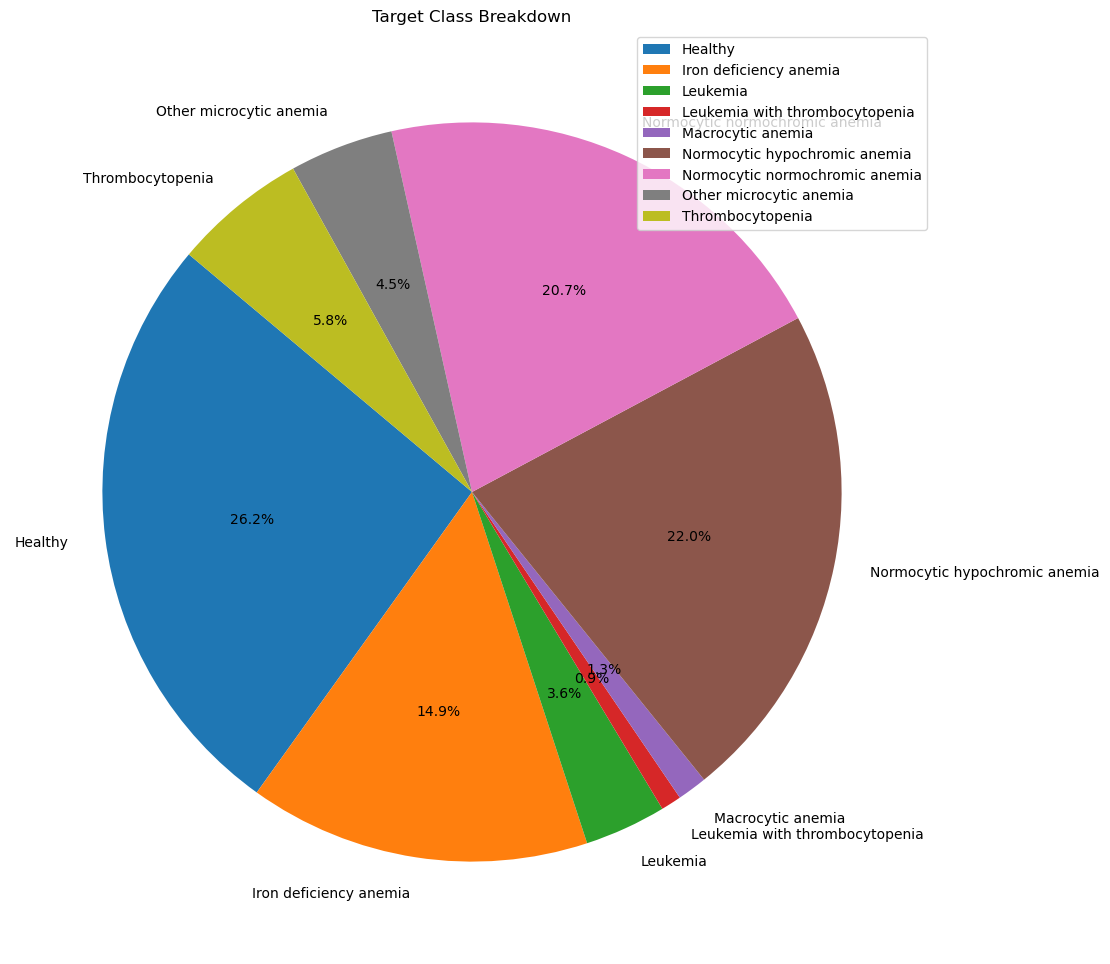

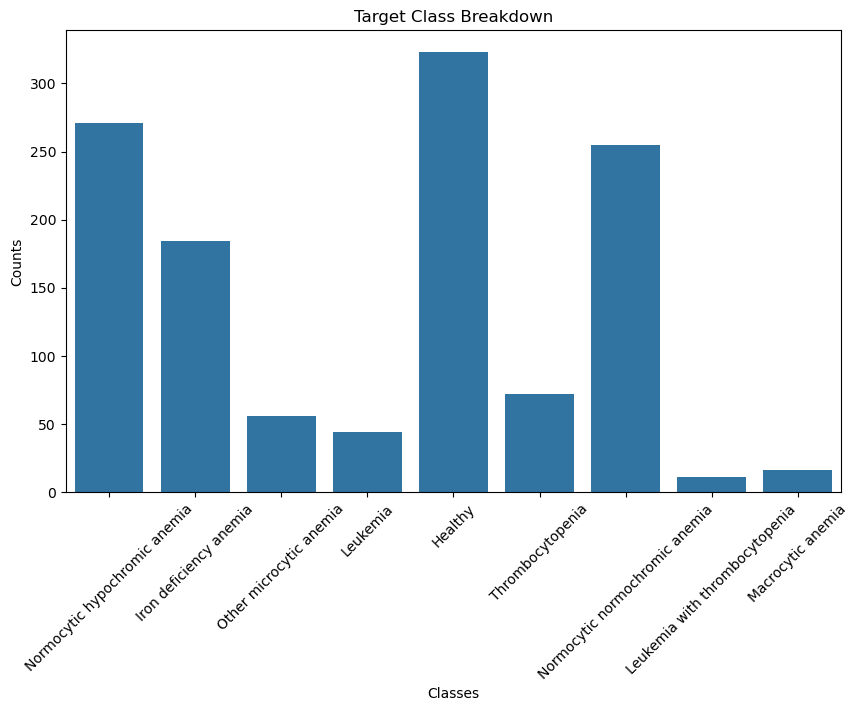

In [15]:
check_class_imbalances(df["Diagnosis"])

In [16]:
df.dtypes

WBC          float64
LYMp         float64
NEUTp        float64
LYMn         float64
NEUTn        float64
RBC          float64
HGB          float64
HCT          float64
MCV          float64
MCH          float64
MCHC         float64
PLT          float64
PDW          float64
PCT          float64
Diagnosis     object
dtype: object

In [17]:
df.describe()

,WBC,LYMp,NEUTp,LYMn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,PDW,PCT
count,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000
mean,7.846713,25.897658,77.591978,1.884341,5.130724,4.714294,12.187589,46.269150,85.734099,32.250877,31.739732,228.927922,14.340931,0.261623
std,3.552180,7.064941,150.651596,1.357362,2.895636,2.867519,3.863201,106.945982,27.663902,113.356653,3.354512,93.080258,3.053868,0.698735
min,0.800000,6.200000,0.700000,0.200000,0.500000,1.360000,-10.000000,2.000000,-79.300000,10.900000,11.500000,10.000000,8.400000,0.010000
25%,6.000000,25.845000,70.775000,1.880760,5.000000,4.190000,10.800000,39.200000,81.000000,25.500000,30.500000,157.000000,13.300000,0.170000
50%,7.400000,25.845000,77.511000,1.880760,5.140940,4.600000,12.200000,46.152600,86.550000,27.700000,32.000000,211.000000,14.312512,0.260280
75%,8.700000,25.845000,77.511000,1.880760,5.140940,5.100000,13.500000,46.152600,90.200000,29.600000,32.900000,290.000000,14.800000,0.260280
max,45.700000,91.400000,5317.000000,41.800000,79.000000,90.800000,87.100000,3715.000000,990.000000,3117.000000,92.800000,660.000000,97.000000,13.600000


# Heat Map

<AxesSubplot:>

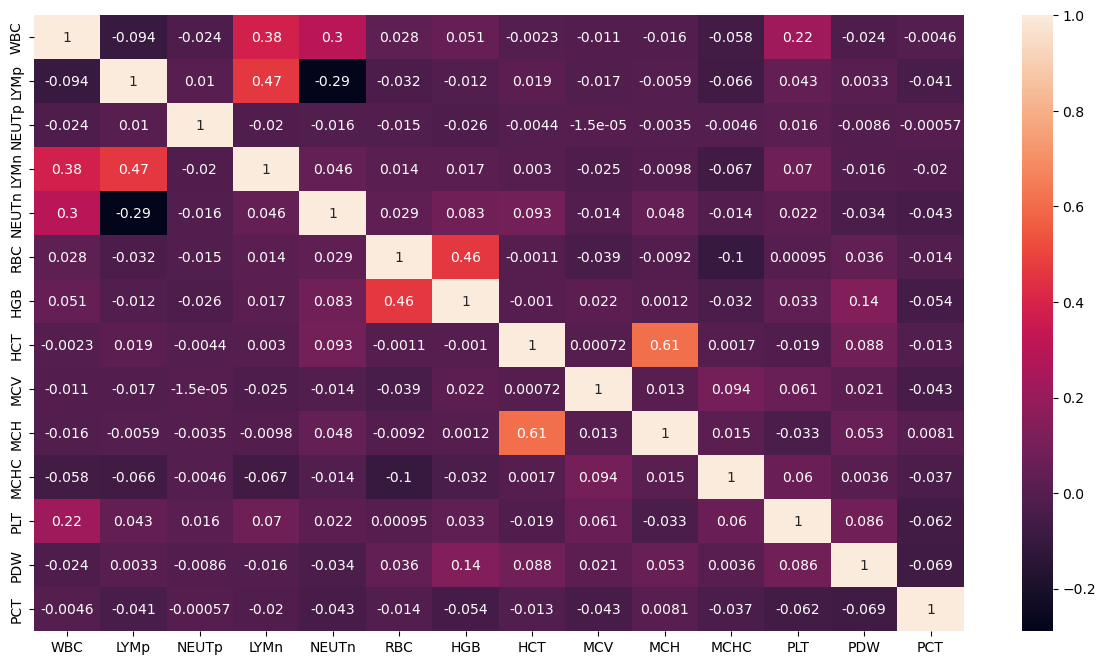

In [19]:
relations= df.drop("Diagnosis", axis=1).corr()
plt.figure(figsize=(15, 8))
sns.heatmap(data=relations, annot=True)

# We have so many dimensions that we're bound to get correlations given the amount of dimensions in the dataset. We might have to do PCA analysis to reduce the dimensions

# Separate Feature Variables

In [20]:
X,y = df.drop("Diagnosis", axis=1), df["Diagnosis"]

# Encode Target Variable

In [21]:
encoder = LabelEncoder()

y_encoded = encoder.fit_transform(y)

# Baseline Model

In [46]:
model = DummyClassifier(strategy="uniform")
pipeline = create_pipeline_object(model)
scores = evaluate_model(X, y_encoded, model)
print(f"Mean Accuracy-Score: {round(np.mean(scores),3)}, STD:{round(np.std(scores),3)}")

Mean Accuracy-Score: 0.108, STD:0.02


# Advanced Model Metrics

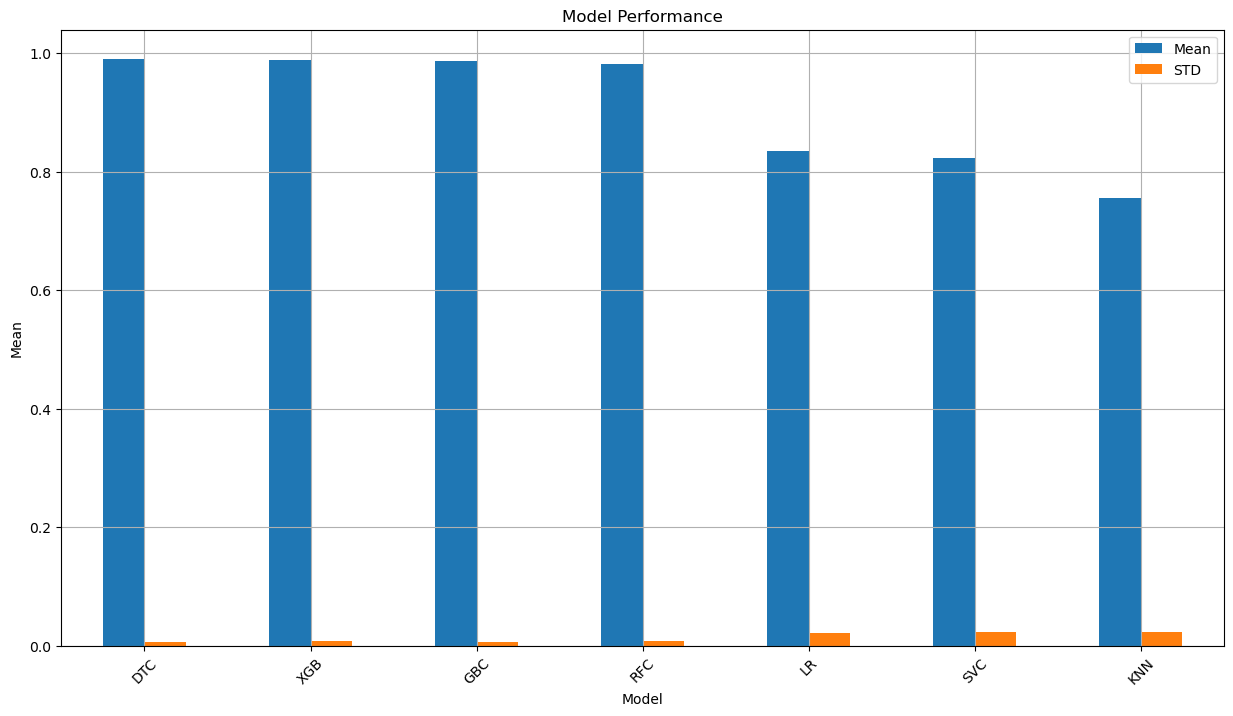

   index Model   Mean    STD
0      4   DTC  0.990  0.007
1      2   XGB  0.989  0.008
2      5   GBC  0.986  0.007
3      3   RFC  0.981  0.008
4      1    LR  0.834  0.021
5      0   SVC  0.823  0.023
6      6   KNN  0.756  0.023


In [74]:
model_names = ["SVC", "LR", "XGB", "RFC", "DTC", "GBC", "KNN"]
models = grab_selected_models(model_names)
tested_selected_models(model_names, models, X, y_encoded)

# Model is likely overfitting due to lack of examples for minority classes

# Lets look at the quality of predictions our off the shelf model creates. 

In [63]:
pipeline = create_pipeline_object()
X_preprocessed = pipeline.fit_transform(X)

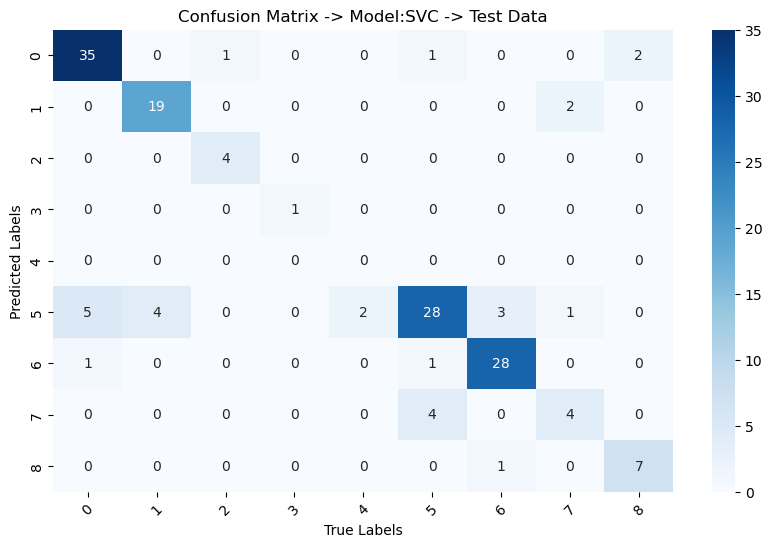

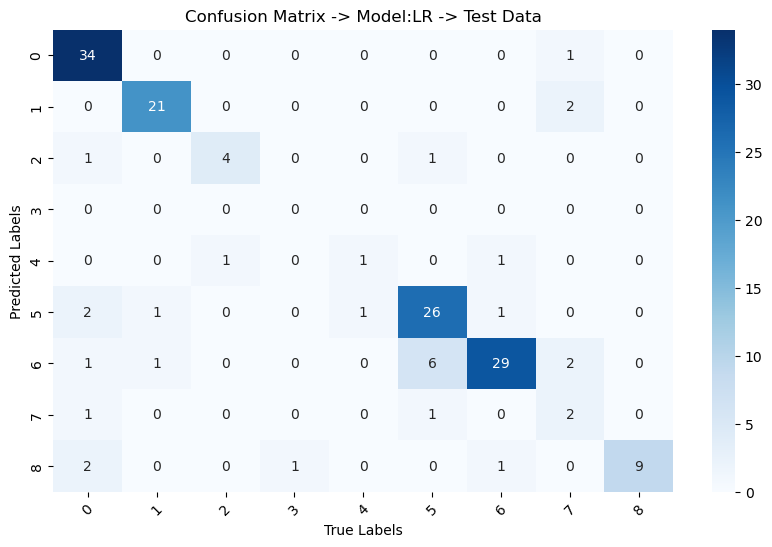

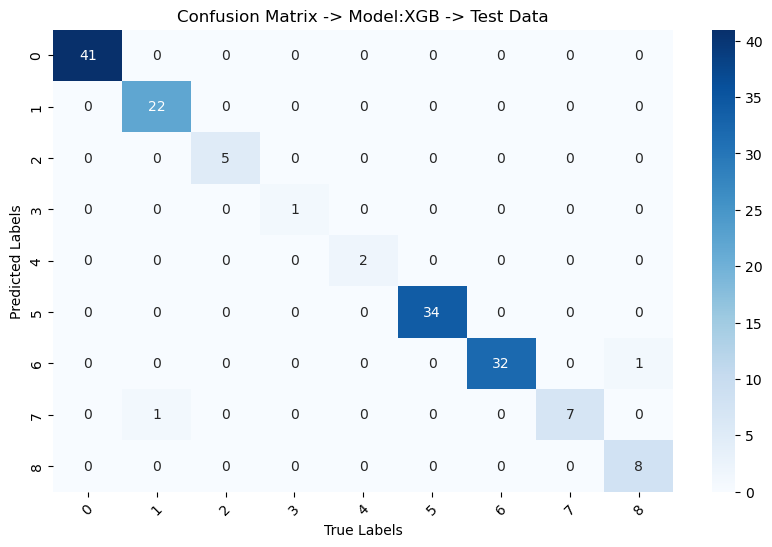

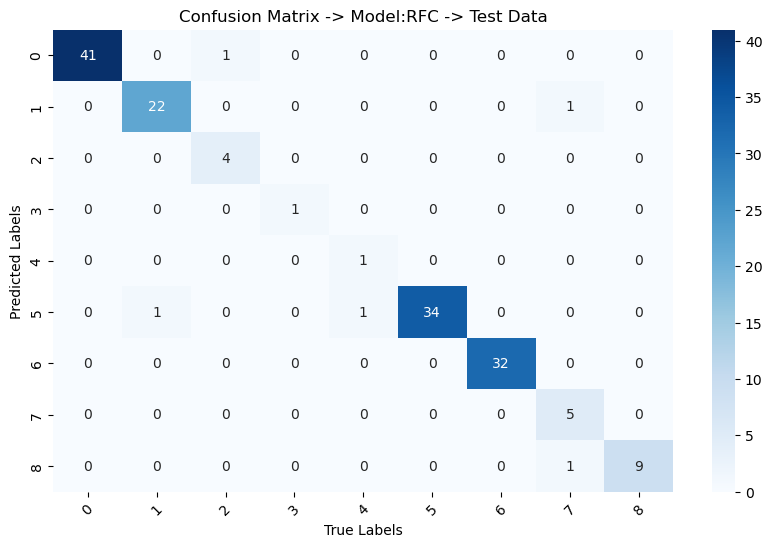

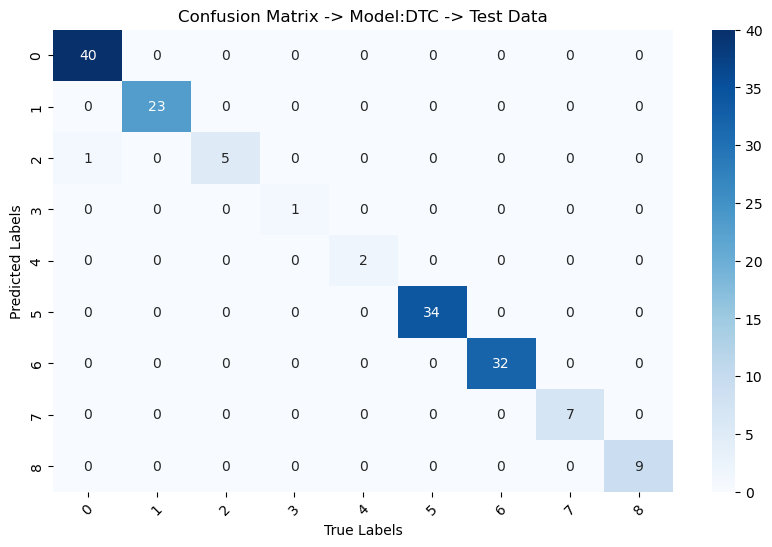

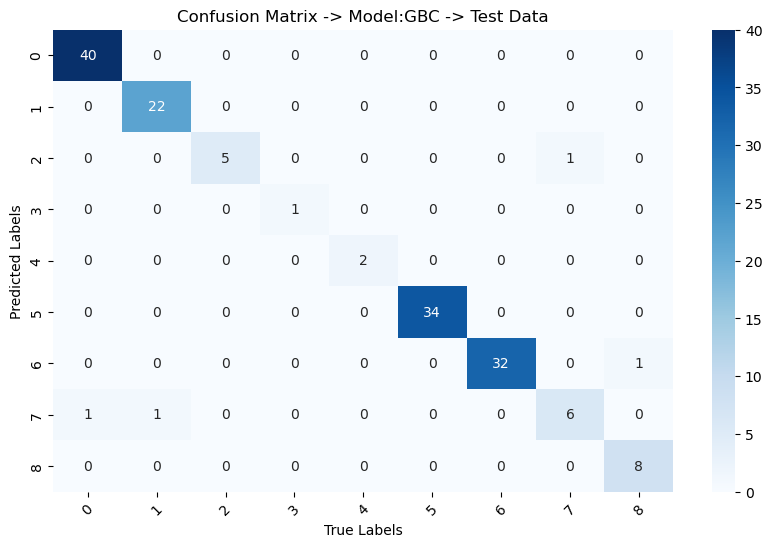

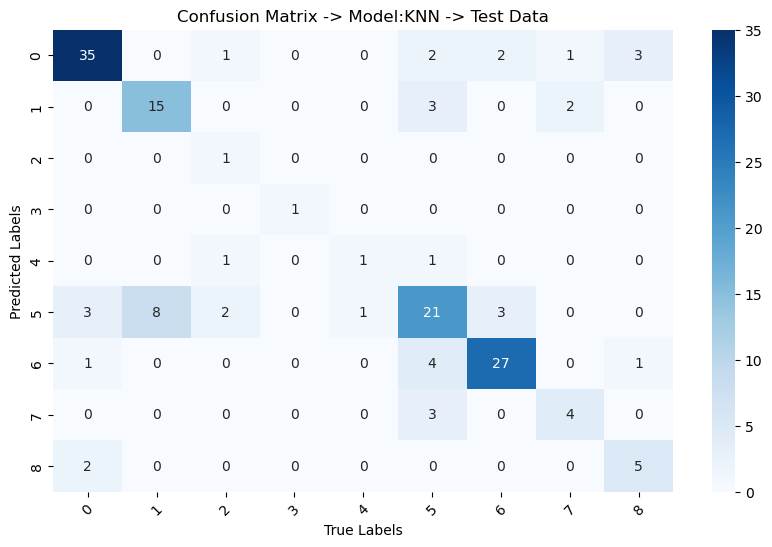

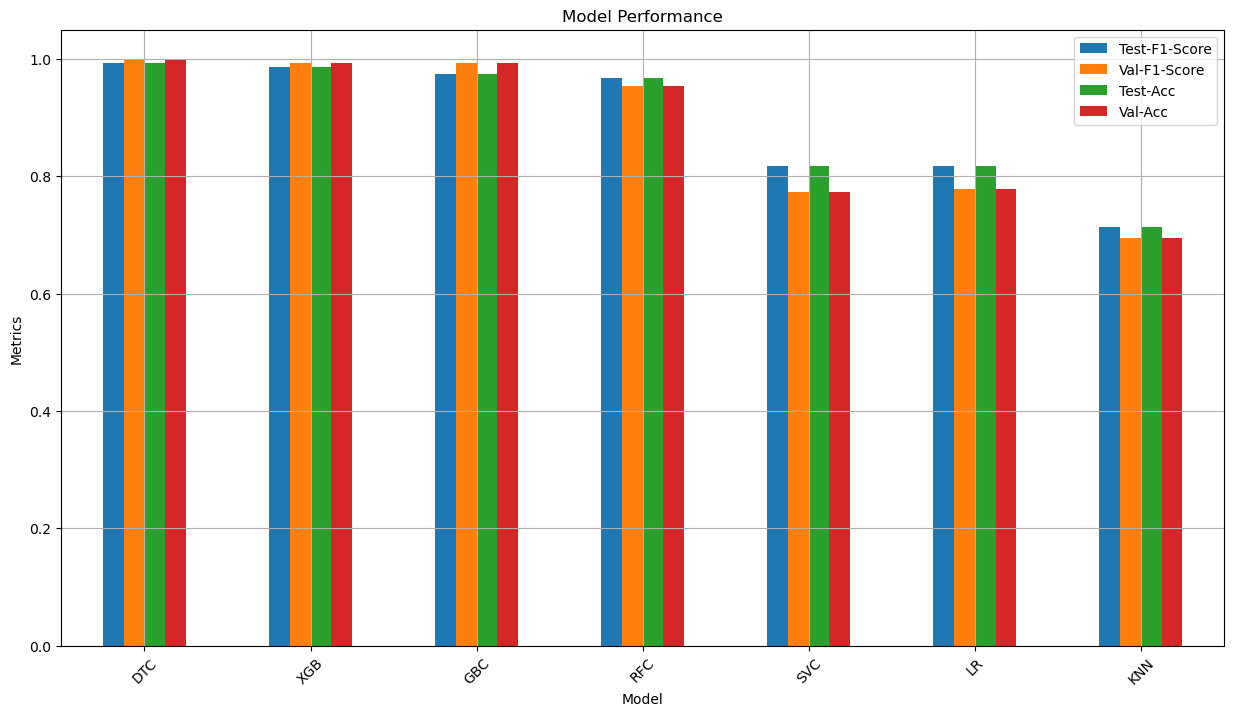

   index Model  Test-F1-Score  Val-F1-Score  Test-Acc   Val-Acc
0      4   DTC       0.993506      1.000000  0.993506  1.000000
1      2   XGB       0.987013      0.993506  0.987013  0.993506
2      5   GBC       0.974026      0.993506  0.974026  0.993506
3      3   RFC       0.967532      0.954545  0.967532  0.954545
4      0   SVC       0.818182      0.772727  0.818182  0.772727
5      1    LR       0.818182      0.779221  0.818182  0.779221
6      6   KNN       0.714286      0.694805  0.714286  0.694805


In [75]:
test_predictions(model_names, models, X_preprocessed, y_encoded)

# Our models are clearly overfitting to the data set which means we will have to implement sampling methods to get the best results.

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

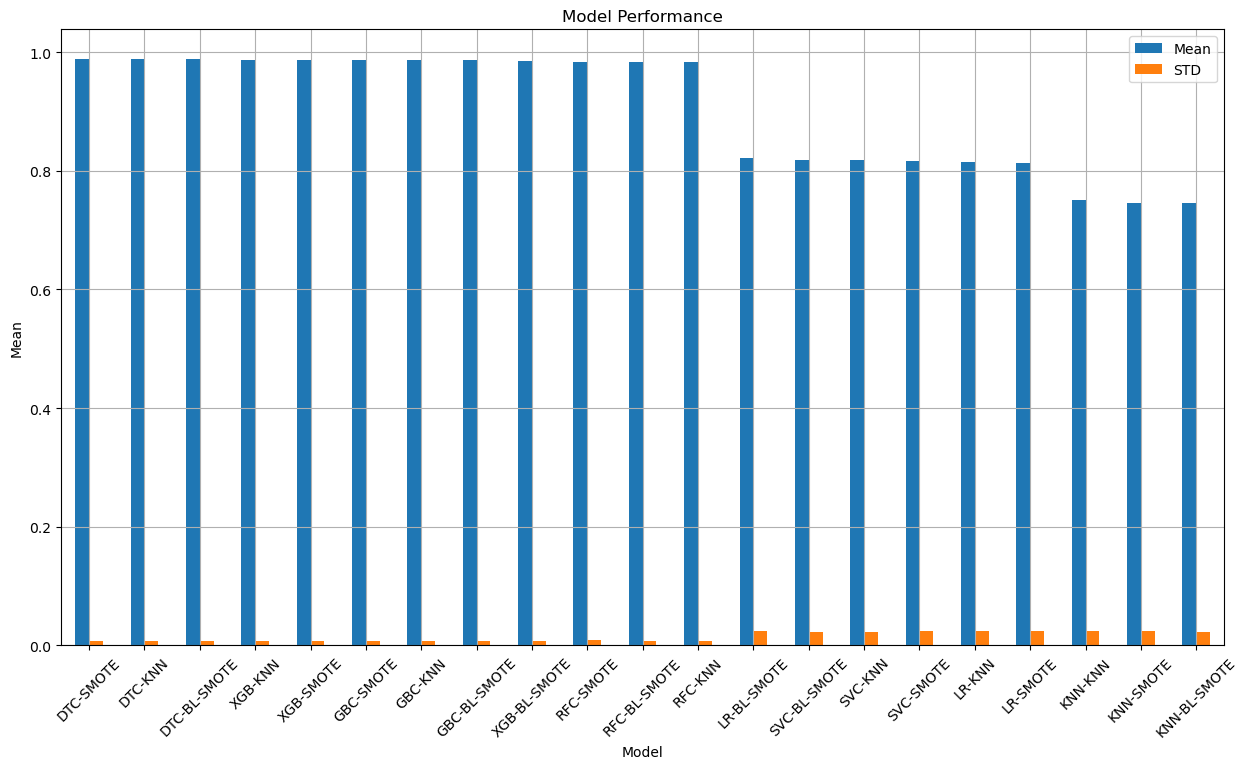

    index         Model   Mean    STD
0       4     DTC-SMOTE  0.989  0.007
1      18       DTC-KNN  0.989  0.007
2      11  DTC-BL-SMOTE  0.988  0.008
3      16       XGB-KNN  0.987  0.008
4       2     XGB-SMOTE  0.987  0.008
5       5     GBC-SMOTE  0.987  0.007
6      19       GBC-KNN  0.987  0.007
7      12  GBC-BL-SMOTE  0.987  0.008
8       9  XGB-BL-SMOTE  0.986  0.008
9       3     RFC-SMOTE  0.984  0.009
10     10  RFC-BL-SMOTE  0.983  0.008
11     17       RFC-KNN  0.983  0.008
12      8   LR-BL-SMOTE  0.821  0.024
13      7  SVC-BL-SMOTE  0.818  0.023
14     14       SVC-KNN  0.818  0.023
15      0     SVC-SMOTE  0.817  0.024
16     15        LR-KNN  0.815  0.024
17      1      LR-SMOTE  0.814  0.024
18     20       KNN-KNN  0.751  0.024
19      6     KNN-SMOTE  0.746  0.024
20     13  KNN-BL-SMOTE  0.745  0.023


In [87]:
sampling_model_names = ["SMOTE","BL-SMOTE","KNN"]
sampling_models = grab_selected_sampling_models(sampling_model_names)

test_sampling_models(sampling_model_names, sampling_models, model_names, models, X_preprocessed, y_encoded)

# DTC seems to perform the best but lets test out all of our models on predictions

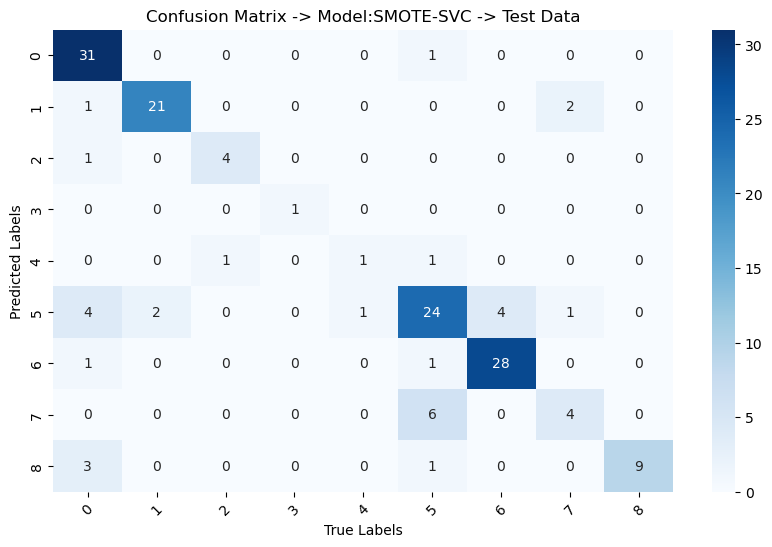

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


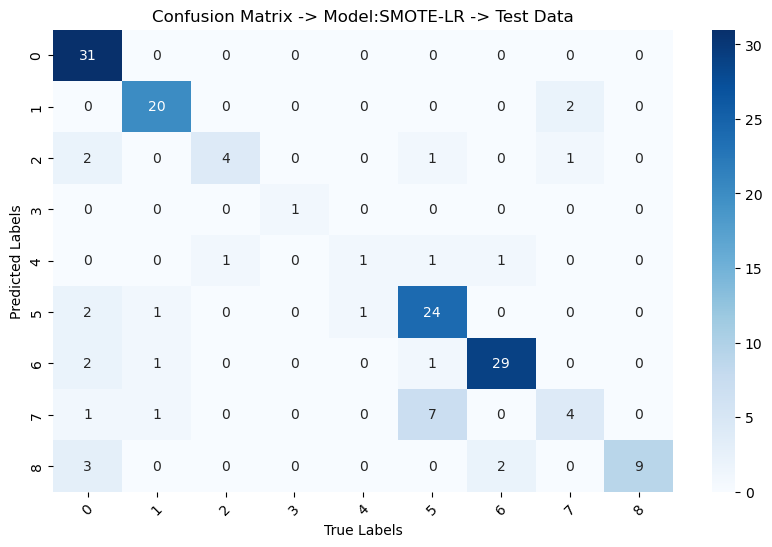

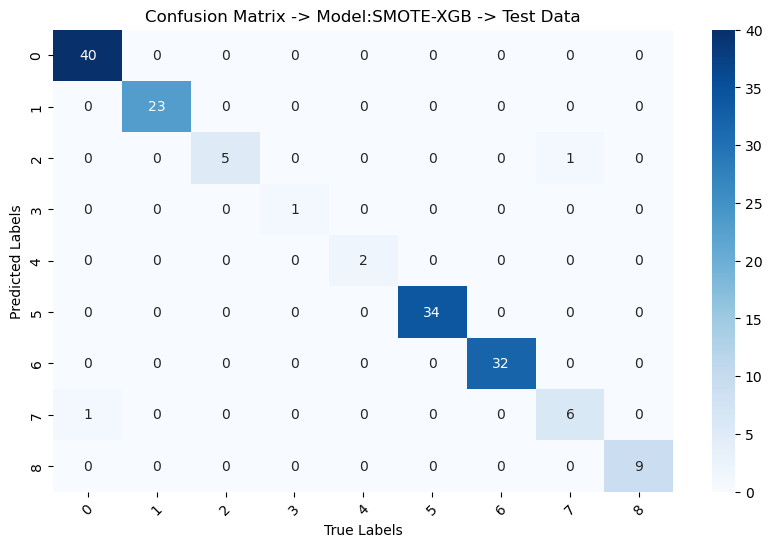

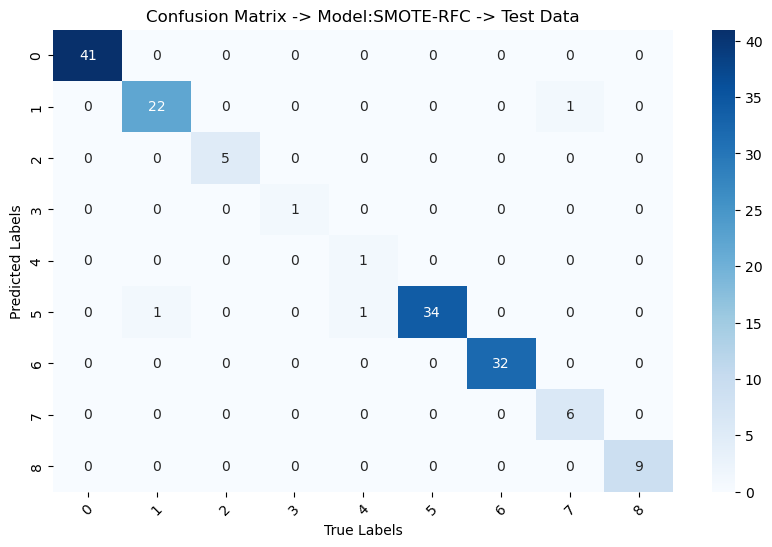

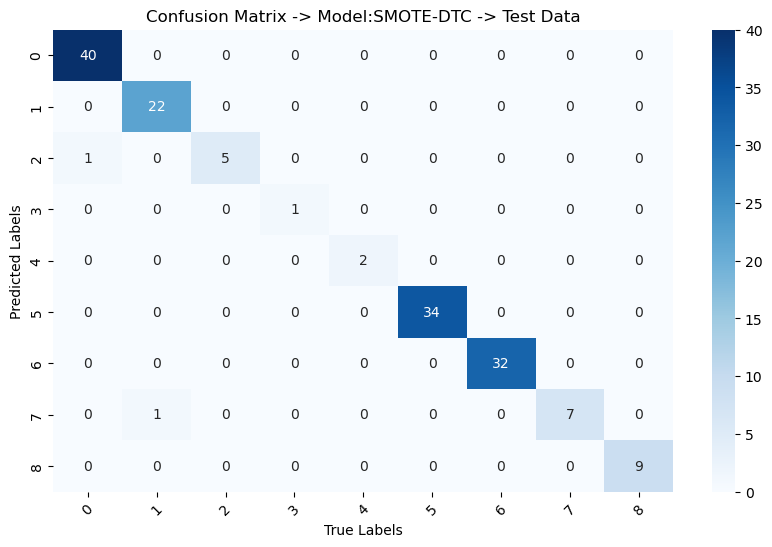

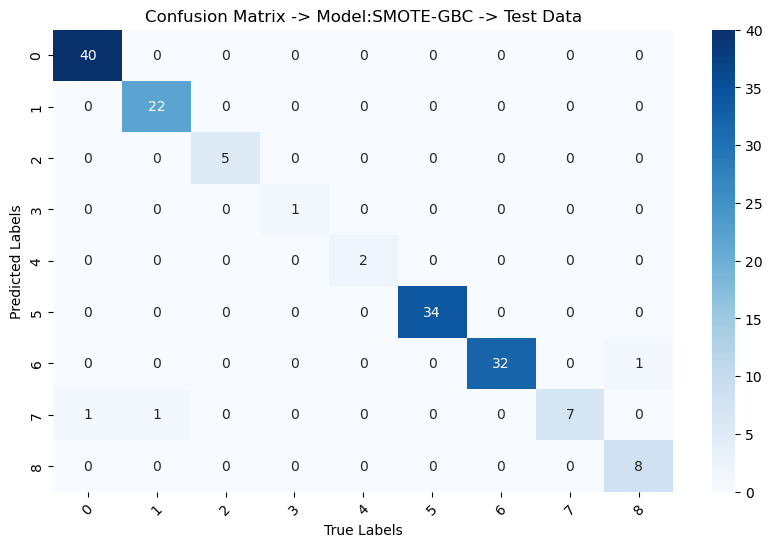

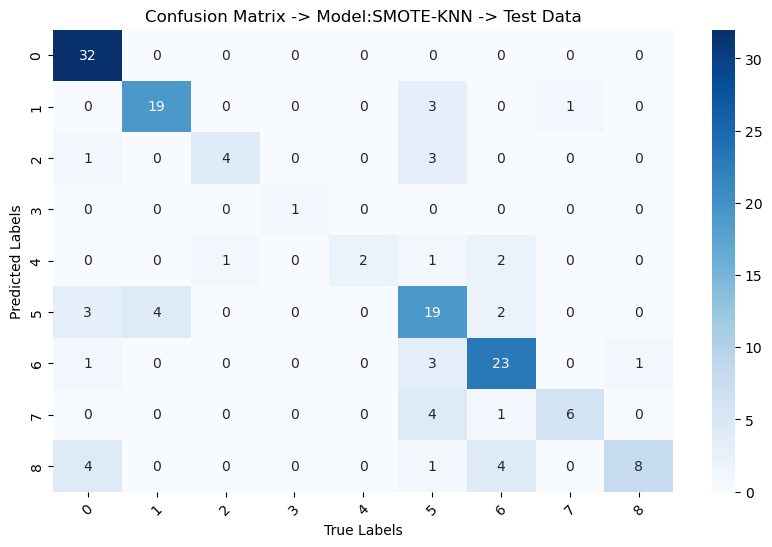

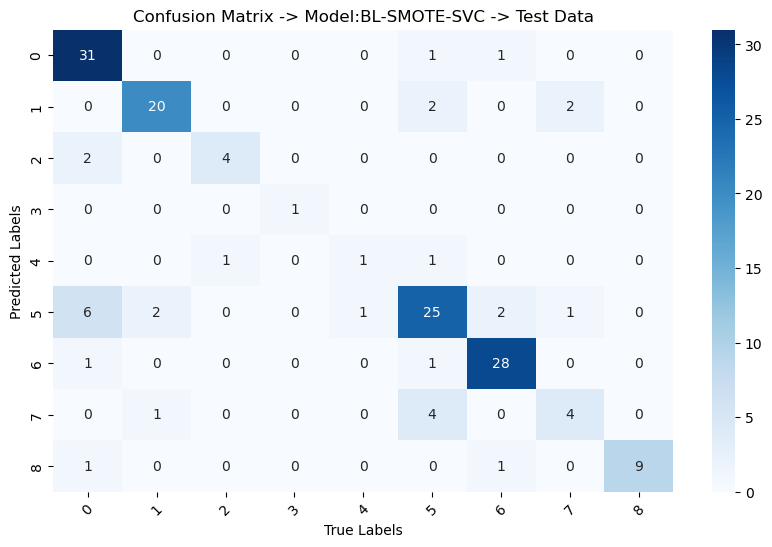

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


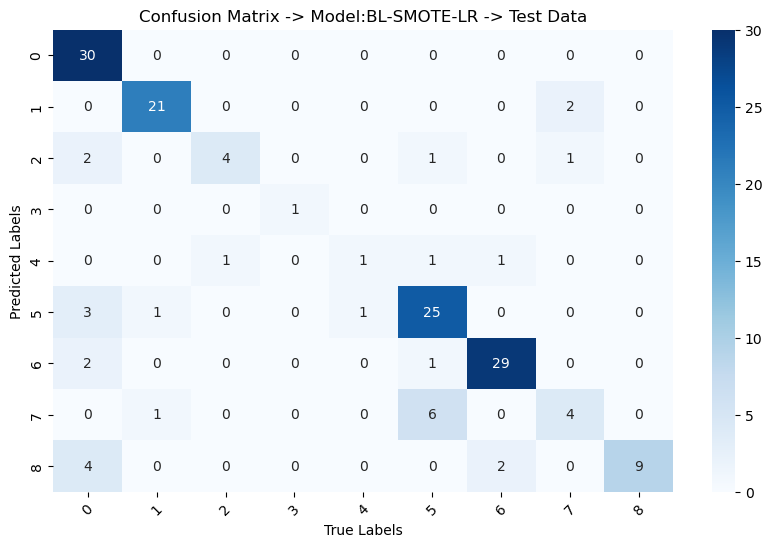

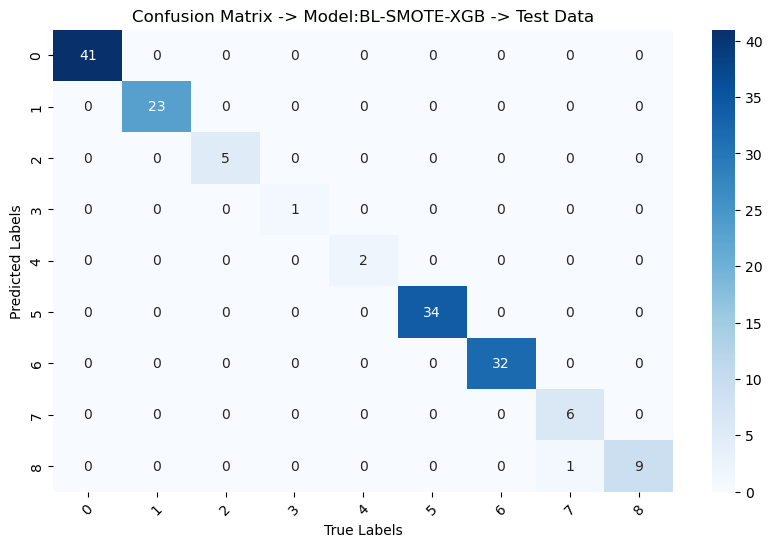

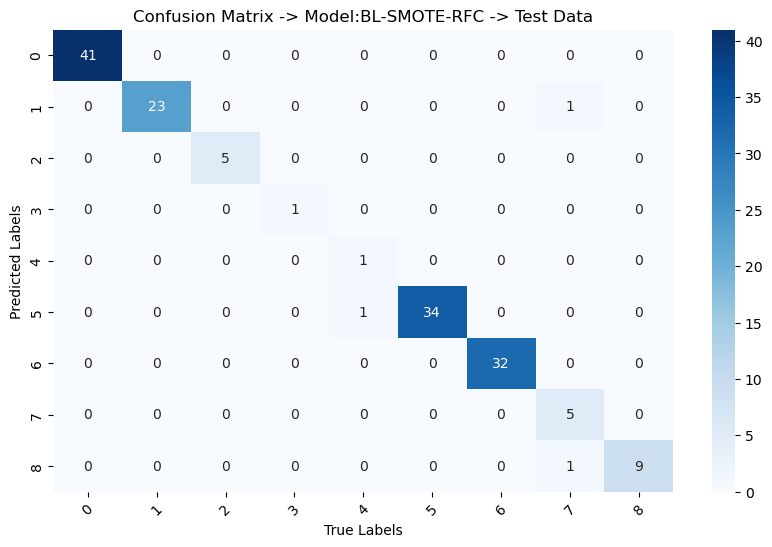

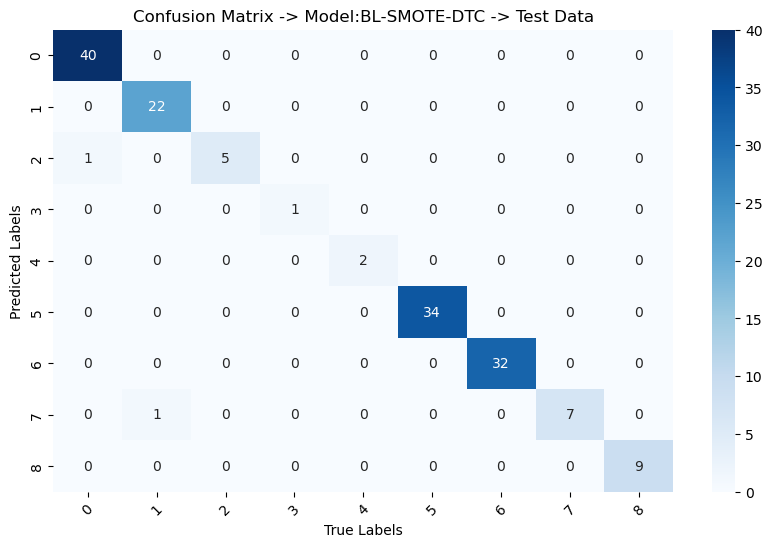

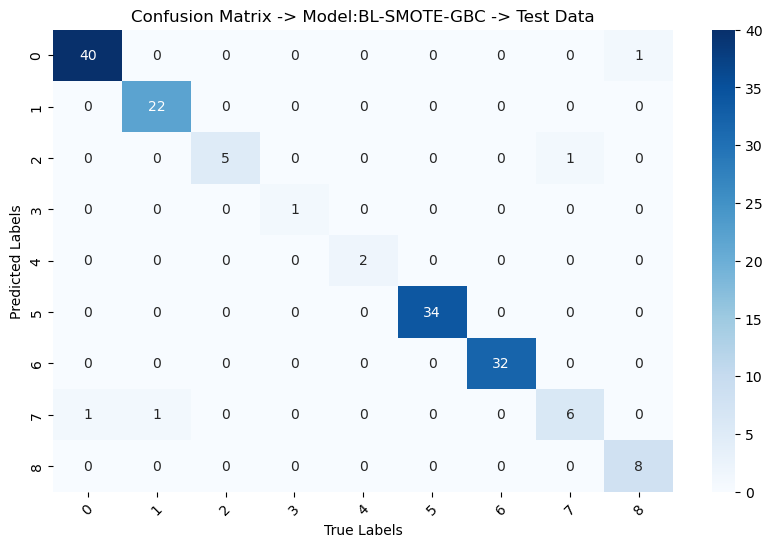

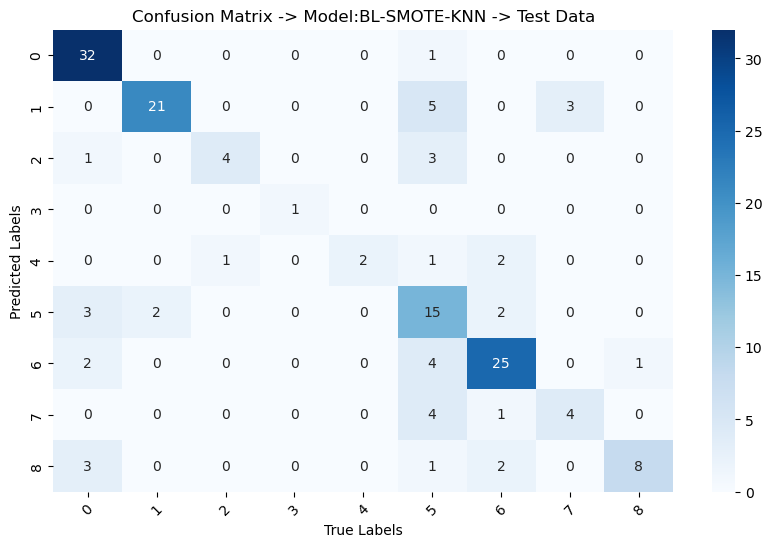

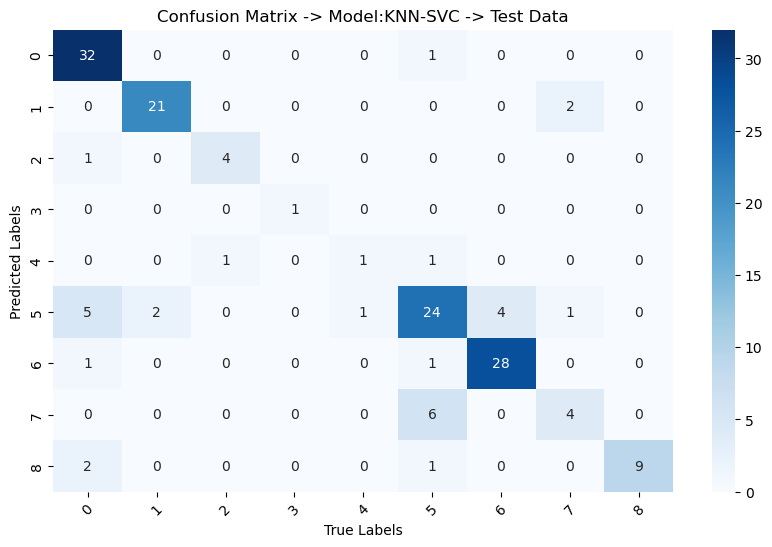

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


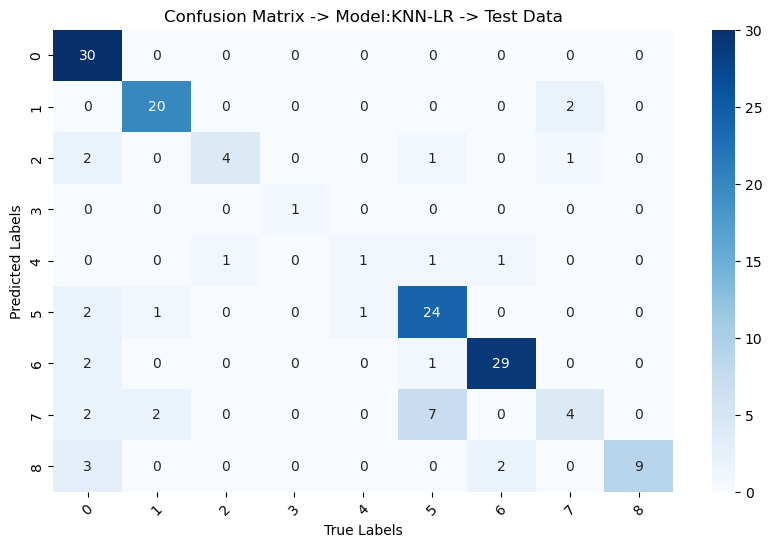

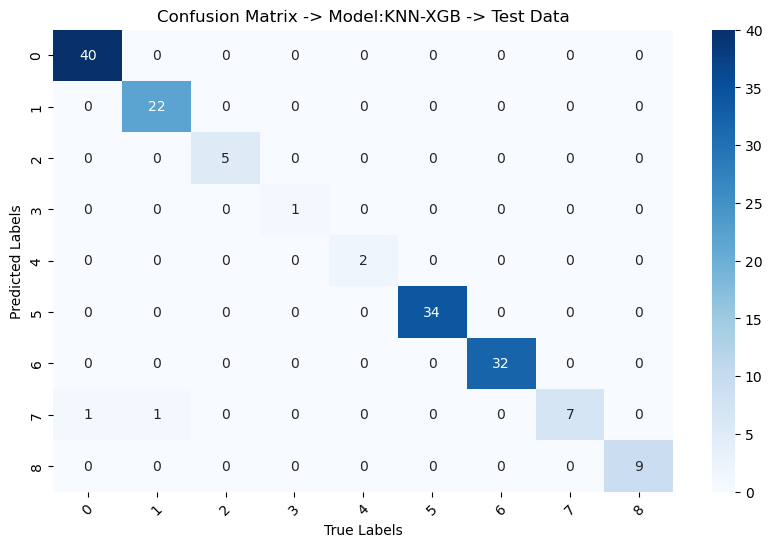

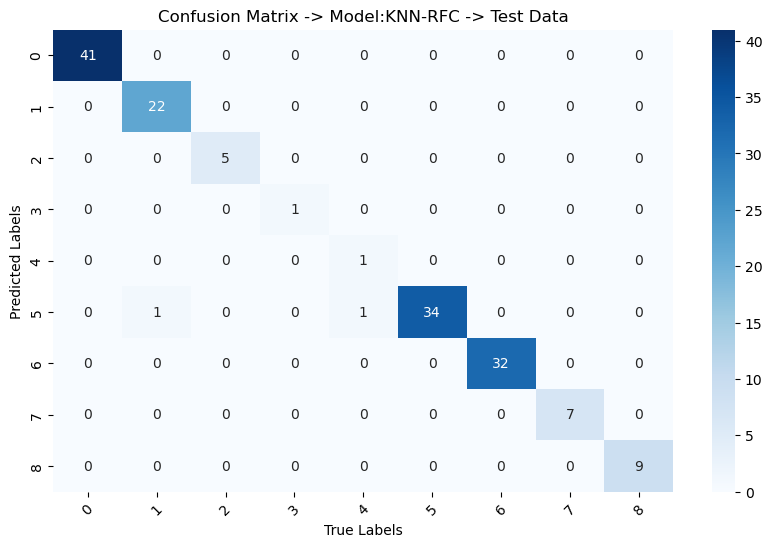

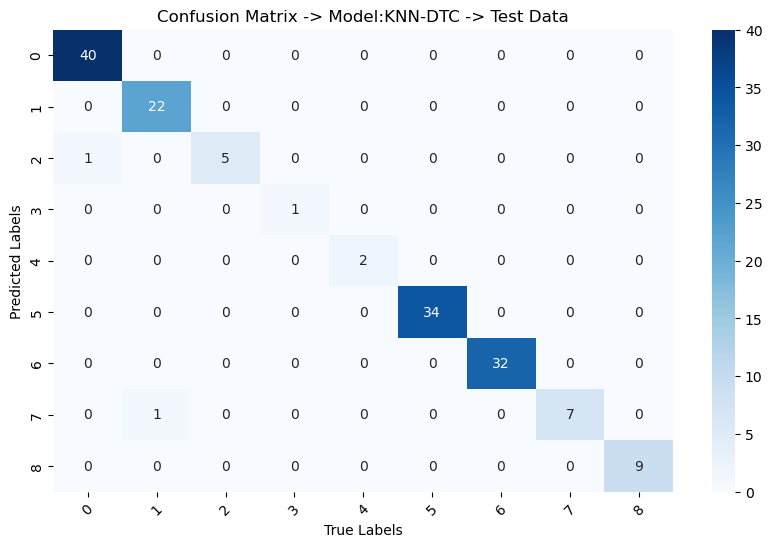

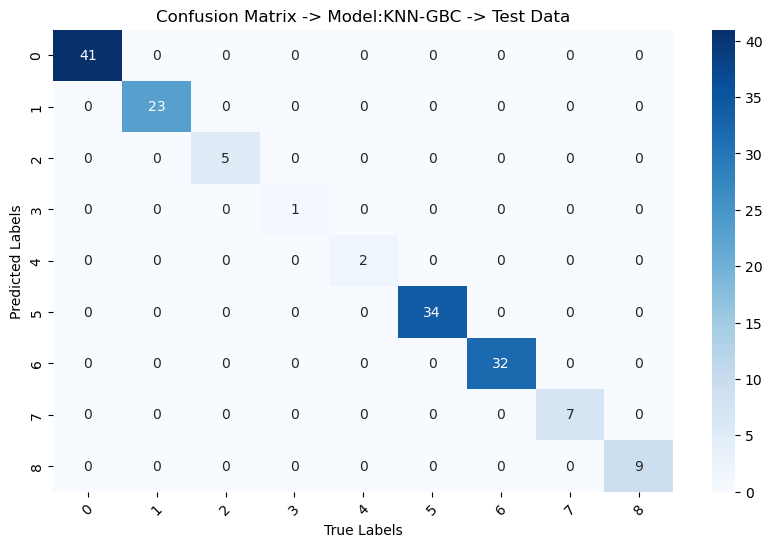

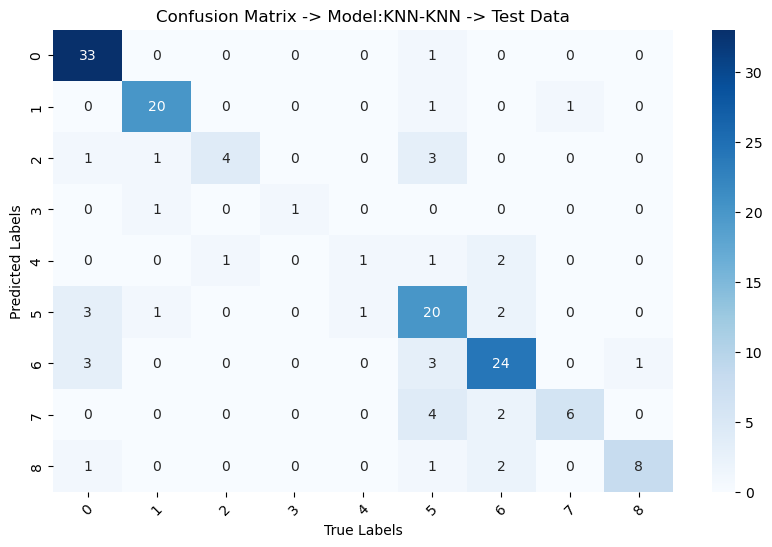

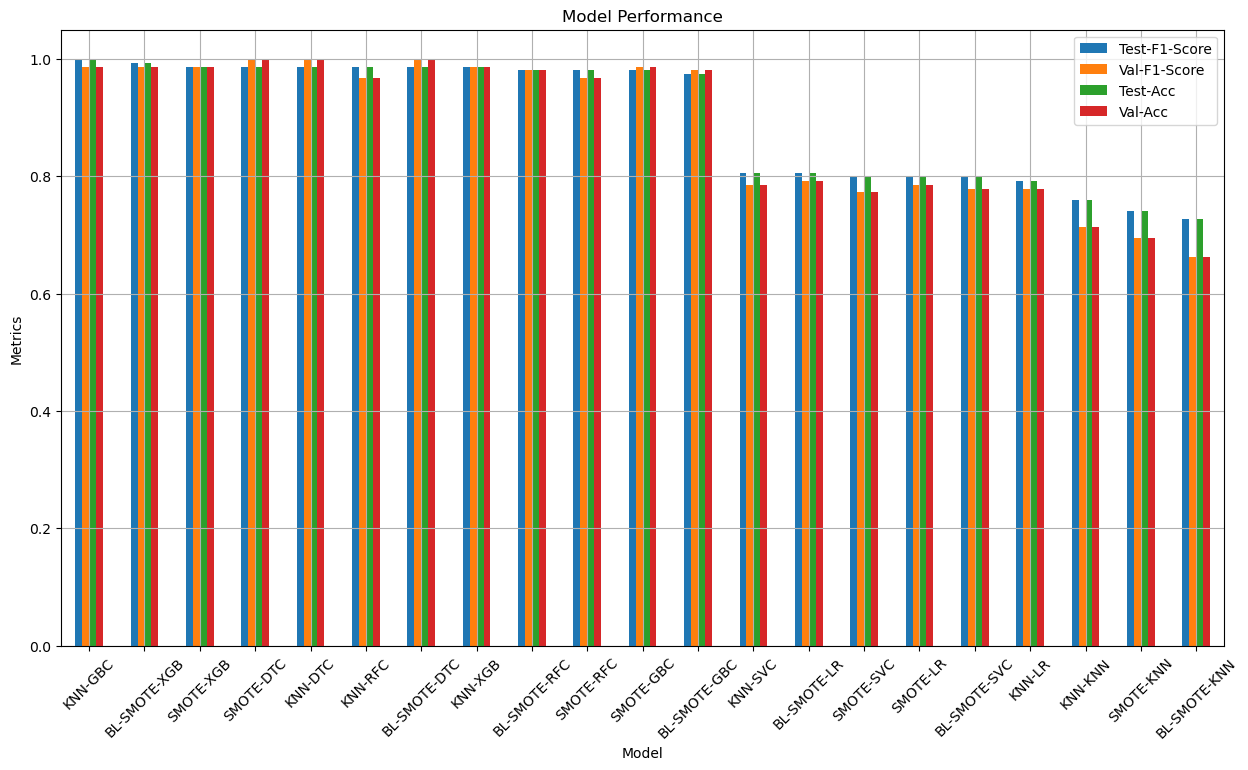

    index         Model  Test-F1-Score  Val-F1-Score  Test-Acc   Val-Acc
0      19       KNN-GBC       1.000000      0.987013  1.000000  0.987013
1       9  BL-SMOTE-XGB       0.993506      0.987013  0.993506  0.987013
2       2     SMOTE-XGB       0.987013      0.987013  0.987013  0.987013
3       4     SMOTE-DTC       0.987013      1.000000  0.987013  1.000000
4      18       KNN-DTC       0.987013      1.000000  0.987013  1.000000
5      17       KNN-RFC       0.987013      0.967532  0.987013  0.967532
6      11  BL-SMOTE-DTC       0.987013      1.000000  0.987013  1.000000
7      16       KNN-XGB       0.987013      0.987013  0.987013  0.987013
8      10  BL-SMOTE-RFC       0.980519      0.980519  0.980519  0.980519
9       3     SMOTE-RFC       0.980519      0.967532  0.980519  0.967532
10      5     SMOTE-GBC       0.980519      0.987013  0.980519  0.987013
11     12  BL-SMOTE-GBC       0.974026      0.980519  0.974026  0.980519
12     14       KNN-SVC       0.805195      0.78571

In [91]:
test_sampling_model_predictions(sampling_model_names, sampling_models, model_names, models, X_preprocessed, y_encoded)